# 1. 安装数据包

In [1]:
# 数据分析的核心库

import sys
import math
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from pandas import datetime
import random
# 时间序列处理
from datetime import datetime
from dateutil.parser import parse as dt_parse
# 正则库
import re
# os库
from os import listdir
# NLTK自然语言处理库
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
# seaborn成对图矩阵生成
from seaborn import pairplot
# sklearn库的归一化、训练集测试集划分
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Keras LSTM
import tensorflow 
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model, layers, initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling1D, Flatten, Activation, GRU
from tensorflow.keras.layers import Multiply, Input,Dense, Dropout, Conv1D, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
# ARIMA 
import statsmodels.api as sm
import statsmodels.tsa as ts
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
import itertools as it
#from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
# sklearn MSE
from sklearn import metrics
from sklearn.metrics import mean_squared_error
# GridSearchCV
from sklearn.model_selection import GridSearchCV

import os
 
os.environ["PATH"] += os.pathsep + 'C:/Users/Administrator/Thesis Programming/情感数据对股票模型预测的影响及神经网络设计/file'

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()


# 2. Pandas 显示设置

In [2]:
# 设置pandas的最大显示行数、列数和输出宽度
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_colwidth', 50)

# 3. 特征工程-模型预处理
## 数据清洗已经完成

In [3]:
#Define a series transformation func.by supervised learning
def series_to_supervised(data, n_in=1):
    # Default para.
    n_out=1
    dropnan=True
    # Fine tune this function. Note that data is the stock data of DataFrame time series 
    # ending with the close column (the column to be predicted)
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Delete the irrelevant secondary state [t] column, leaving 
    # only the close [t] column to be predicted 
    # and the state feature [t-1] column of the previous time
    agg.drop(agg.columns[[x for x in range(data.shape[1], 2*data.shape[1]-1)]], axis=1, inplace=True)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
# 损失图绘制
def drawLossGraph(_history, title, num):
    
    #损失图绘制，观察最优epochs
    #:param _history: 训练历史
    #:param title: 图表标题
    #:param num: 图表编号
    #:return: 无
    
    plt.plot(_history.history['loss'], color='g', label='train')
    plt.plot(_history.history['val_loss'], color='r', label='test')
    plt.title('Fig'+num+'. '+title)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    # 保存于 new_test_file/result/
    #savingPath = 'file/Fig'+num+'_'+title.replace(' ', '_')+'.png'
    #plt.savefig(savingPath, dpi=400, bbox_inches='tight')
    # 展示
    plt.show()

In [5]:
# 定义反归一化函数
def inverse_transform_col(_scaler, y, n_col):
    """
    对某个列进行反归一化处理的函数
    :param _scaler: sklearn归一化模型
    :param y: 需要反归一化的数据列
    :param n_col: y在归一化时所属的列编号
    :return: y的反归一化结果
    """
    y = y.copy()
    y -= _scaler.min_[n_col]
    y /= _scaler.scale_[n_col]
    return y

In [6]:
# 模型预测结果绘图函数
def predictGraph(yTrain, yPredict, yTest, timelabels, title, num):
    """
    预测结果图像绘制函数
    :param yTrain: 训练集结果
    :param yPredict: 验证集的预测结果
    :param yTest: 验证集的真实结果
    :param timelabels: x轴刻度标签
    :param title: 图表标题
    :param num: 图标编号
    :return: 无
    """
    len_yTrain = yTrain.shape[0]
    len_y = len_yTrain+yPredict.shape[0]
    # 真实曲线绘制
    plt.plot(np.concatenate([yTrain,yTest]), color='r', label='sample')
    # 预测曲线绘制
    plt.plot([x for x in range(len_yTrain,len_y)],yPredict, color='g', label='predict')
    # 标题和轴标签
    plt.title('Fig'+num+'. '+title)
    plt.xlabel('date')
    plt.ylabel('close')
    plt.legend()
    # 刻度和刻度标签
    xticks = [0,len_yTrain,len_y-1]
    xtick_labels = [timelabels[x] for x in xticks]
    plt.xticks(ticks=xticks, labels=xtick_labels, rotation=30)
    # 保存于 new_test_file/result/
    #savingPath = 'file/Fig'+num+'_'+title.replace(' ', '_')+'.png'
    #plt.savefig(savingPath, dpi=400, bbox_inches='tight')
    # 展示
    plt.show()

# 4. 循环网络的搭建

## 4.1 情感数据影响下的LSTM v.s. 纯技术指标影响下的LSTM 

### 情感数据影响下的LSTM

In [7]:
# 读取数据
LSTMwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv', parse_dates=['Date'], index_col='Date').values
LSTMwithEmotion 

array([[3.16843323e+02, 3.48339996e+02, 3.14733337e+02, ...,
        4.88038517e-02, 7.20361750e-02, 3.41619995e+02],
       [3.41563324e+02, 3.64980011e+02, 3.33813324e+02, ...,
        7.68664389e-02, 8.51711347e-02, 3.39476654e+02],
       [3.46553345e+02, 3.56959991e+02, 3.43593323e+02, ...,
        5.11512681e-02, 8.35095523e-02, 3.45953339e+02],
       ...,
       [2.29500000e+02, 2.29820007e+02, 2.17250000e+02, ...,
        6.25000000e-02, 1.60282258e-01, 2.20190002e+02],
       [2.19800003e+02, 2.22929993e+02, 2.17779999e+02, ...,
        1.42857143e-02, 9.02331002e-02, 2.22039993e+02],
       [2.08279999e+02, 2.15550003e+02, 2.02000000e+02, ...,
        6.95105820e-02, 5.45836710e-02, 2.07279999e+02]])

In [8]:
# Normalization
# Feature_range from (0,1) in default
scaler_LSTM = MinMaxScaler(feature_range=(0,1))
# Fitting model
scaler_LSTM = scaler_LSTM.fit(LSTMwithEmotion)
# To normalize the data
LSTMwithEmotion = scaler_LSTM.fit_transform(LSTMwithEmotion)

# Partial arraries' demonstration
LSTMwithEmotion[:6,:]

array([[0.53504974, 0.66746527, 0.55351887, 1.        , 0.0976077 ,
        0.27013566, 0.6665528 ],
       [0.65651201, 0.75110585, 0.6472013 , 0.99145809, 0.15373288,
        0.31939176, 0.65609646],
       [0.68103059, 0.71079344, 0.69522093, 0.52462323, 0.10230254,
        0.31316082, 0.68769312],
       [0.72795466, 0.7277495 , 0.73355156, 0.30353597, 0.12098622,
        0.28073713, 0.75140664],
       [0.75014738, 0.78506798, 0.76466451, 0.35640165, 0.0975209 ,
        0.26562413, 0.81151011],
       [0.90651203, 0.95291869, 0.89463179, 0.44844756, 0.09171244,
        0.14868238, 0.97389986]])

In [9]:
# 使用series_to_supervised函数构建有监督数据集
LSTMwithEmotion = series_to_supervised(LSTMwithEmotion)
LSTMwithEmotion

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.535050,0.667465,0.553519,1.000000,0.097608,0.270136,0.666553,0.656096
2,0.656512,0.751106,0.647201,0.991458,0.153733,0.319392,0.656096,0.687693
3,0.681031,0.710793,0.695221,0.524623,0.102303,0.313161,0.687693,0.751407
4,0.727955,0.727750,0.733552,0.303536,0.120986,0.280737,0.751407,0.811510
5,0.750147,0.785068,0.764665,0.356402,0.097521,0.265624,0.811510,0.973900
...,...,...,...,...,...,...,...,...
175,0.063876,0.051270,0.063830,0.273399,0.094843,0.355849,0.056152,0.000000
176,0.078911,0.053833,0.010606,0.383393,0.000000,0.625000,0.000000,0.070056
177,0.010269,0.031717,0.036579,0.289135,0.400000,0.000000,0.070056,0.074154
178,0.105886,0.071728,0.074877,0.266095,0.125000,0.601058,0.074154,0.083179


In [10]:
# It must be specified that the dtype of darray is float32 (default float64), 
#  otherwise the subsequent input of LSTM model will report an error
LSTMwithEmotion = LSTMwithEmotion.values.astype(np.float32)
# Training set: verification set=7:3
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(LSTMwithEmotion[:,:-1], LSTMwithEmotion[:,-1], test_size=0.3, shuffle=False)


In [11]:
# Building LSTM model based on Keras function
# Reshape X_ Train and X_ test：
# reshape input to be 3D [samples, timesteps, features]
X_train_LSTM = X_train_LSTM.reshape((X_train_LSTM.shape[0], 1, X_train_LSTM.shape[1]))
X_test_LSTM = X_test_LSTM.reshape((X_test_LSTM.shape[0], 1, X_test_LSTM.shape[1]))

print(len(X_train_LSTM))
print(len(X_test_LSTM))

125
54


In [12]:
X_train_LSTM.shape

(125, 1, 7)

In [13]:
# Establish LSTM neural network model and train the model
def LSTM_Generator(Xtrain, Xtest, ytrain, ytest):
   
    
    _model = Sequential()
    _model.add(LSTM(64,return_sequences=True,input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    _model.add(Dropout(0.2))
    
    _model.add(Dense(1, activation='relu'))
    # compile
    _model.compile(loss='mse', optimizer='adam')
    # train the model
    _history = _model.fit(Xtrain, ytrain, epochs=35, batch_size=20, validation_data=(Xtest, ytest), shuffle=False, verbose=1)
    return _history,_model
  
history_LSTM, model_LSTM = LSTM_Generator(X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM)

Train on 125 samples, validate on 54 samples
Epoch 1/35
125/125 [==============================] - 1s 11ms/sample - loss: 0.3103 - val_loss: 0.1218
Epoch 2/35
125/125 [==============================] - 0s 135us/sample - loss: 0.2992 - val_loss: 0.0931
Epoch 3/35
125/125 [==============================] - 0s 136us/sample - loss: 0.2521 - val_loss: 0.0633
Epoch 4/35
125/125 [==============================] - 0s 136us/sample - loss: 0.1875 - val_loss: 0.0394
Epoch 5/35
125/125 [==============================] - 0s 128us/sample - loss: 0.1321 - val_loss: 0.0234
Epoch 6/35
125/125 [==============================] - 0s 143us/sample - loss: 0.0891 - val_loss: 0.0150
Epoch 7/35
125/125 [==============================] - 0s 128us/sample - loss: 0.0561 - val_loss: 0.0131
Epoch 8/35
125/125 [==============================] - 0s 136us/sample - loss: 0.0374 - val_loss: 0.0154
Epoch 9/35
125/125 [==============================] - 0s 128us/sample - loss: 0.0281 - val_loss: 0.0190
Epoch 10/35
125/125 

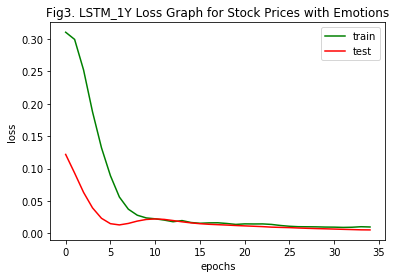

In [14]:
# 绘制Loss曲线
drawLossGraph(history_LSTM, title='LSTM_1Y Loss Graph for Stock Prices with Emotions', num='3')

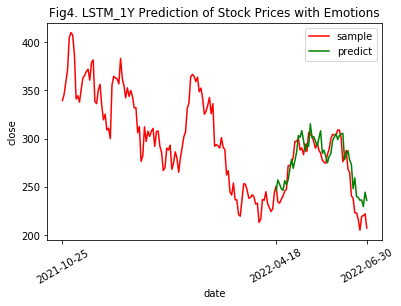

In [15]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_LSTM = model_LSTM.predict(X_test_LSTM)[:,0]

# 反归一化
# 重新读取 TSLA股票价格融合情感.csv
LSTMwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv')
col_n_LSTM = LSTMwithEmotion.shape[1]-2
# 预测结果反归一化
inv_yPredict_LSTM = inverse_transform_col(scaler_LSTM, y_predict_LSTM, col_n_LSTM)
# 真实结果反归一化
inv_yTest_LSTM = inverse_transform_col(scaler_LSTM, y_test_LSTM, col_n_LSTM)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_LSTM = inverse_transform_col(scaler_LSTM, y_train_LSTM, col_n_LSTM)
# 绘图
predictGraph(inv_yTrain_LSTM, inv_yPredict_LSTM, inv_yTest_LSTM, timelabels=LSTMwithEmotion['Date'].values, title='LSTM_1Y Prediction of Stock Prices with Emotions', num='4')


In [16]:
print(model_LSTM.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             18432     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 1)              65        
Total params: 18,497
Trainable params: 18,497
Non-trainable params: 0
_________________________________________________________________
None


### 纯技术指标影响下的LSTM

In [17]:
# 创建标准化功能打包函数 
def formatData(sharePricesData):
    """
    模式化样本数据的函数
    :param sharePricesData: 样本数据的DataFrame
    :return: X_train, X_test, y_train, y_test, scaler
    """
    # 归一化
    _scaler = MinMaxScaler()
    _scaler = _scaler.fit(sharePricesData)
    sharePricesData = _scaler.fit_transform(sharePricesData)
    # 构建有监督数据集
    sharePricesData = series_to_supervised(sharePricesData)
    # dtype为float32
    sharePricesData = sharePricesData.values.astype(np.float32)
    # 训练集和验证集的划分
    _X_train, _X_test, _y_train, _y_test = train_test_split(sharePricesData[:,:-1], sharePricesData[:,-1], test_size=0.3, shuffle=False)
    # reshape input
    _X_train = _X_train.reshape((_X_train.shape[0], 1, _X_train.shape[1]))
    _X_test = _X_test.reshape((_X_test.shape[0], 1, _X_test.shape[1]))
    return _X_train, _X_test, _y_train, _y_test, _scaler

In [18]:
# 批量反归一化
def invTransformMulti(_scaler, _y_predict, _y_test, _y_train, _col_n):
    
    _inv_yPredict = inverse_transform_col(_scaler, _y_predict, _col_n)
    _inv_yTest = inverse_transform_col(_scaler, _y_test, _col_n)
    _inv_yTrain = inverse_transform_col(_scaler, _y_train, _col_n)
    return _inv_yPredict, _inv_yTest, _inv_yTrain

In [19]:
# 读取数据
sharePricesTSLA_pureLSTM = pd.read_csv('file/one_year/one_result/TSLA_stockprice_1Y.csv', parse_dates=['Date'], index_col='Date').values
# 标准化数据输入
X_train_pureLSTM, X_test_pureLSTM, y_train_pureLSTM, y_test_pureLSTM, scaler_pureLSTM = formatData(sharePricesTSLA_pureLSTM)


In [20]:
print(len(X_train_pureLSTM))
print(len(X_test_pureLSTM))

175
75


In [21]:
# 建模
history_pureLSTM, model_pureLSTM = LSTM_Generator(X_train_pureLSTM, X_test_pureLSTM, y_train_pureLSTM, y_test_pureLSTM)


Train on 175 samples, validate on 75 samples
Epoch 1/35
175/175 [==============================] - 1s 7ms/sample - loss: 0.3131 - val_loss: 0.1145
Epoch 2/35
175/175 [==============================] - 0s 120us/sample - loss: 0.2725 - val_loss: 0.0779
Epoch 3/35
175/175 [==============================] - 0s 114us/sample - loss: 0.1980 - val_loss: 0.0467
Epoch 4/35
175/175 [==============================] - 0s 108us/sample - loss: 0.1290 - val_loss: 0.0249
Epoch 5/35
175/175 [==============================] - 0s 103us/sample - loss: 0.0759 - val_loss: 0.0125
Epoch 6/35
175/175 [==============================] - 0s 108us/sample - loss: 0.0437 - val_loss: 0.0081
Epoch 7/35
175/175 [==============================] - 0s 103us/sample - loss: 0.0253 - val_loss: 0.0088
Epoch 8/35
175/175 [==============================] - 0s 103us/sample - loss: 0.0163 - val_loss: 0.0109
Epoch 9/35
175/175 [==============================] - 0s 114us/sample - loss: 0.0155 - val_loss: 0.0120
Epoch 10/35
175/175 [

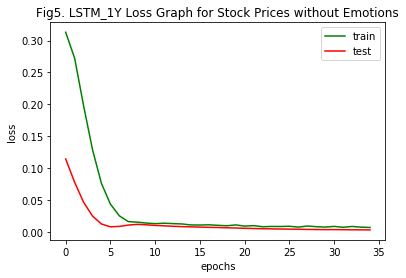

In [22]:
# 纯技术指标的LSTM损失函数绘图
drawLossGraph(history_pureLSTM, title='LSTM_1Y Loss Graph for Stock Prices without Emotions', num='5')

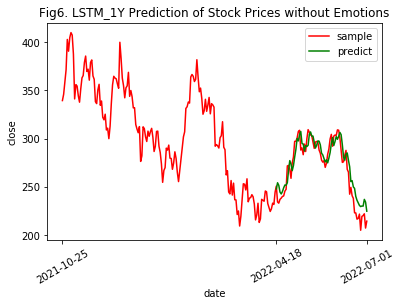

In [23]:
# 预测
y_predict_pureLSTM = model_pureLSTM.predict(X_test_pureLSTM)[:,0]
# 反归一化
sharePricesTSLA_pureLSTM = pd.read_csv('file/one_year/one_result/TSLA_stockprice_1Y.csv')
col_n_pureLSTM = sharePricesTSLA_pureLSTM.shape[1]-2
inv_yPredict_pureLSTM, inv_yTest_pureLSTM, inv_yTrain_pureLSTM = invTransformMulti(scaler_pureLSTM, y_predict_pureLSTM, y_test_pureLSTM, y_train_pureLSTM, col_n_pureLSTM)
# 绘图
predictGraph(inv_yTrain_pureLSTM, inv_yPredict_pureLSTM, inv_yTest_pureLSTM, timelabels=sharePricesTSLA_pureLSTM['Date'].values, title='LSTM_1Y Prediction of Stock Prices without Emotions', num='6')


In [24]:
print(model_pureLSTM.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 64)             17920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              65        
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________
None


### MSE MAE R_square 估值

In [25]:
# 含情感数据的LSTM---输出MSE MAE R方评估值
MSE_error_LSTM = mean_squared_error(y_test_LSTM, y_predict_LSTM)  
print('The Mean Squared Error is {}'.format(MSE_error_LSTM))
print('The Root Mean Squared Error is:')
print(math.sqrt(MSE_error_LSTM))
print('The Mean Absolute Error is:',mean_absolute_error(y_test_LSTM, y_predict_LSTM))
print('R Square is {}'.format(r2_score(y_test_LSTM, y_predict_LSTM)))

The Mean Squared Error is 0.0054155089892446995
The Root Mean Squared Error is:
0.07359014192977684
The Mean Absolute Error is: 0.060900193
R Square is 0.7564973970982726


In [26]:
# 纯技术指标影响的LSTM——输出MSE MAE R方评估值
MSE_error_pureLSTM = mean_squared_error(y_test_pureLSTM, y_predict_pureLSTM) 
print('The Mean Squared Error is {}'.format(MSE_error_pureLSTM))
print('The Root Mean Squared Error is:')
print(math.sqrt(MSE_error_pureLSTM))
print('The Mean Absolute Error is:',mean_absolute_error(y_test_pureLSTM, y_predict_pureLSTM))
print('R Square is {}'.format(r2_score(y_test_pureLSTM, y_predict_pureLSTM)))

The Mean Squared Error is 0.0032669513020664454
The Root Mean Squared Error is:
0.05715725065174536
The Mean Absolute Error is: 0.048129715
R Square is 0.8542329812104463


In [27]:
MSE_error_LSTM = mean_squared_error(y_test_LSTM, y_predict_LSTM)
RMSE_LSTM = math.sqrt(MSE_error_LSTM)
MAE_LSTM = mean_absolute_error(y_test_LSTM, y_predict_LSTM)


In [28]:
MSE_error_pureLSTM = mean_squared_error(y_test_pureLSTM, y_predict_pureLSTM)
RMSE_pureLSTM = math.sqrt(MSE_error_pureLSTM)
MAE_pureLSTM = mean_absolute_error(y_test_pureLSTM, y_predict_pureLSTM)


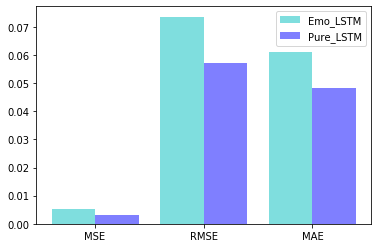

In [29]:
# 绘制估值比较图
x = np.arange(3)
emo_lstm = [MSE_error_LSTM,RMSE_LSTM,MAE_LSTM]
pure_lstm = [MSE_error_pureLSTM,RMSE_pureLSTM,MAE_pureLSTM]
 
bar_width = 0.4
tick_label = ["MSE", "RMSE", "MAE"]
plt.bar(x, emo_lstm, align="center", color="c",width=bar_width,label="Emo_LSTM",alpha=0.5)
plt.bar(x+bar_width, pure_lstm, align="center",color="b",width=bar_width,label="Pure_LSTM",alpha=0.5)
plt.xticks(x+bar_width/2, tick_label)
plt.legend()
plt.show()

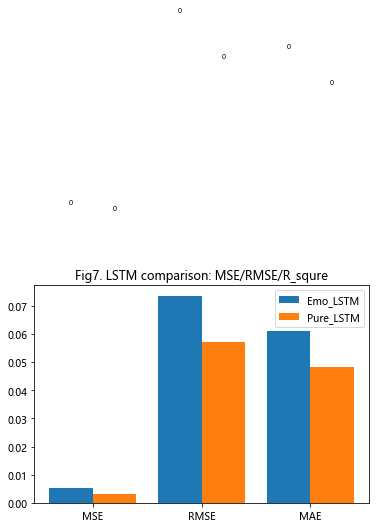

In [30]:
# 绘制估值比较图
#import matplotlib
#import matplotlib.pyplot as plt
#import numpy as np

def drawHistogram(title, num):
    matplotlib.rc("font", family='MicroSoft YaHei')
    list1 = np.array([MSE_error_LSTM,RMSE_LSTM,MAE_LSTM])   # 柱状图第一组数据
    list2 = np.array([MSE_error_pureLSTM,RMSE_pureLSTM,MAE_pureLSTM])   # 柱状图第二组数据
    length = len(list1)
    x = np.arange(length)   # 横坐标范围
    x_label = ["MSE", "RMSE", "MAE"]

    plt.figure()
    total_width, n = 0.8, 2   # 柱状图总宽度，有几组数据
    width = total_width / n   # 单个柱状图的宽度
    x1 = x - width / 2   # 第一组数据柱状图横坐标起始位置
    x2 = x1 + width   # 第二组数据柱状图横坐标起始位置
    # 标题
    plt.title('Fig'+num+'. '+title)

    
    # plt.xlabel("星期")   # 横坐标label 此处可以不添加
    plt.bar(x1, list1, width=width, label="Emo_LSTM")
    plt.bar(x2, list2, width=width, label="Pure_LSTM")
    for a, b in zip(x1, list1):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=7)

    for a, b in zip(x2, list2):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=7)

    plt.xticks(x, x_label)   
    plt.legend()   # 给出图例
    
    # 保存于 file/
    #savingPath = 'file/Fig'+num+'_'+title.replace(' ', '_')+'.png'
    #plt.savefig(savingPath, dpi=400, bbox_inches='tight')
    plt.show()

if __name__ == '__main__':
    drawHistogram(title = 'LSTM comparison: MSE/RMSE/R_squre', num = '7')


## 4.2 含情感数据的股票模型搭建

### 4.2.1 含情感数据的BI-LSTM建模及预测

In [31]:
# 读取数据
BIwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv', parse_dates=['Date'], index_col='Date').values
BIwithEmotion

array([[3.16843323e+02, 3.48339996e+02, 3.14733337e+02, ...,
        4.88038517e-02, 7.20361750e-02, 3.41619995e+02],
       [3.41563324e+02, 3.64980011e+02, 3.33813324e+02, ...,
        7.68664389e-02, 8.51711347e-02, 3.39476654e+02],
       [3.46553345e+02, 3.56959991e+02, 3.43593323e+02, ...,
        5.11512681e-02, 8.35095523e-02, 3.45953339e+02],
       ...,
       [2.29500000e+02, 2.29820007e+02, 2.17250000e+02, ...,
        6.25000000e-02, 1.60282258e-01, 2.20190002e+02],
       [2.19800003e+02, 2.22929993e+02, 2.17779999e+02, ...,
        1.42857143e-02, 9.02331002e-02, 2.22039993e+02],
       [2.08279999e+02, 2.15550003e+02, 2.02000000e+02, ...,
        6.95105820e-02, 5.45836710e-02, 2.07279999e+02]])

In [32]:
# 生成归一化容器
# feature_range参数沿用默认(0,1)
scaler_BI = MinMaxScaler(feature_range=(0,1))
# 训练模型
scaler_BI = scaler_BI.fit(BIwithEmotion)
# 归一化
BIwithEmotion = scaler_BI.fit_transform(BIwithEmotion)

# 部分结果展示
BIwithEmotion[:6,:]

array([[0.53504974, 0.66746527, 0.55351887, 1.        , 0.0976077 ,
        0.27013566, 0.6665528 ],
       [0.65651201, 0.75110585, 0.6472013 , 0.99145809, 0.15373288,
        0.31939176, 0.65609646],
       [0.68103059, 0.71079344, 0.69522093, 0.52462323, 0.10230254,
        0.31316082, 0.68769312],
       [0.72795466, 0.7277495 , 0.73355156, 0.30353597, 0.12098622,
        0.28073713, 0.75140664],
       [0.75014738, 0.78506798, 0.76466451, 0.35640165, 0.0975209 ,
        0.26562413, 0.81151011],
       [0.90651203, 0.95291869, 0.89463179, 0.44844756, 0.09171244,
        0.14868238, 0.97389986]])

In [33]:
#使用series_to_supervised函数构建有监督数据集
BIwithEmotion = series_to_supervised(BIwithEmotion)
BIwithEmotion

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.535050,0.667465,0.553519,1.000000,0.097608,0.270136,0.666553,0.656096
2,0.656512,0.751106,0.647201,0.991458,0.153733,0.319392,0.656096,0.687693
3,0.681031,0.710793,0.695221,0.524623,0.102303,0.313161,0.687693,0.751407
4,0.727955,0.727750,0.733552,0.303536,0.120986,0.280737,0.751407,0.811510
5,0.750147,0.785068,0.764665,0.356402,0.097521,0.265624,0.811510,0.973900
...,...,...,...,...,...,...,...,...
175,0.063876,0.051270,0.063830,0.273399,0.094843,0.355849,0.056152,0.000000
176,0.078911,0.053833,0.010606,0.383393,0.000000,0.625000,0.000000,0.070056
177,0.010269,0.031717,0.036579,0.289135,0.400000,0.000000,0.070056,0.074154
178,0.105886,0.071728,0.074877,0.266095,0.125000,0.601058,0.074154,0.083179


In [34]:
# 必须规定ndarray的dtype为float32（默认float64），否则后续输入LSTM模型报错
BIwithEmotion = BIwithEmotion.values.astype(np.float32)
# 训练集:验证集=7:3
X_train_BI, X_test_BI, y_train_BI, y_test_BI = train_test_split(BIwithEmotion[:,:-1], BIwithEmotion[:,-1], test_size=0.3, shuffle=False)


In [35]:
#基于Keras函数的BILSTM模型搭建
#重塑X_train和X_test：
# reshape input to be 3D [samples, timesteps, features]
X_train_BI = X_train_BI.reshape((X_train_BI.shape[0], 1, X_train_BI.shape[1]))
X_test_BI = X_test_BI.reshape((X_test_BI.shape[0], 1, X_test_BI.shape[1]))

print(len(X_train_BI))
print(len(X_test_BI))

125
54


In [36]:
def BILSTM_Generator(Xtrain, Xtest, ytrain, ytest):
   
    # Build BILSTM model
    _model = Sequential()
    _model.add(Bidirectional(LSTM(64,return_sequences=True,input_shape=(Xtrain.shape[1], Xtrain.shape[2]))))
    _model.add(Dropout(0.2))
    
    _model.add(Dense(1, activation='relu'))
    # compile
    _model.compile(loss='mse', optimizer='adam')
    # train the model
    _history = _model.fit(Xtrain, ytrain, epochs=35, batch_size=20, validation_data=(Xtest, ytest), shuffle=False, verbose=1)
    return _history,_model
  
history_BI, model_BI = BILSTM_Generator(X_train_BI, X_test_BI, y_train_BI, y_test_BI)

Train on 125 samples, validate on 54 samples
Epoch 1/35
125/125 [==============================] - 2s 17ms/sample - loss: 0.2733 - val_loss: 0.0740
Epoch 2/35
125/125 [==============================] - 0s 160us/sample - loss: 0.1789 - val_loss: 0.0382
Epoch 3/35
125/125 [==============================] - 0s 120us/sample - loss: 0.1046 - val_loss: 0.0172
Epoch 4/35
125/125 [==============================] - 0s 127us/sample - loss: 0.0578 - val_loss: 0.0090
Epoch 5/35
125/125 [==============================] - 0s 143us/sample - loss: 0.0299 - val_loss: 0.0097
Epoch 6/35
125/125 [==============================] - 0s 215us/sample - loss: 0.0181 - val_loss: 0.0135
Epoch 7/35
125/125 [==============================] - 0s 152us/sample - loss: 0.0168 - val_loss: 0.0158
Epoch 8/35
125/125 [==============================] - 0s 176us/sample - loss: 0.0159 - val_loss: 0.0147
Epoch 9/35
125/125 [==============================] - 0s 152us/sample - loss: 0.0138 - val_loss: 0.0124
Epoch 10/35
125/125 

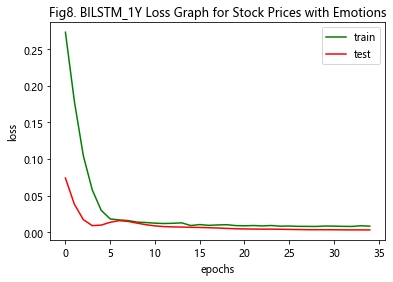

In [37]:
#绘制BILSTM损失图
drawLossGraph(history_BI, title='BILSTM_1Y Loss Graph for Stock Prices with Emotions', num='8')

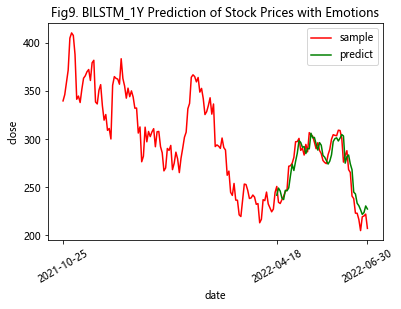

In [38]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_BI = model_BI.predict(X_test_BI)[:,0]

# 反归一化
# 重新读取 TSLA股票价格融合情感.csv
BIwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv')
col_n_BI = BIwithEmotion.shape[1]-2
# 预测结果反归一化
inv_yPredict_BI = inverse_transform_col(scaler_BI, y_predict_BI, col_n_BI)
# 真实结果反归一化
inv_yTest_BI = inverse_transform_col(scaler_BI, y_test_BI, col_n_BI)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_BI = inverse_transform_col(scaler_BI, y_train_BI, col_n_BI)
# 绘图
predictGraph(inv_yTrain_BI, inv_yPredict_BI, inv_yTest_BI, timelabels=BIwithEmotion['Date'].values, title='BILSTM_1Y Prediction of Stock Prices with Emotions', num='9')


In [39]:
# 输出MSE MAE R方评估值
MSE_error_BI = mean_squared_error(y_test_BI,y_predict_BI)
RMSE_BI = math.sqrt(MSE_error_BI)
MAE_BI = mean_absolute_error(y_test_BI,y_predict_BI)
R_square_BI = r2_score(y_test_BI,y_predict_BI)
print('The Mean Squared Error is {}'.format(MSE_error_BI))
print('The Root Mean Squared Error is:')
print(RMSE_BI)
print('The Mean Absolute Error is:',MAE_BI)
print('R Square is {}'.format(R_square_BI))

The Mean Squared Error is 0.0031142609659582376
The Root Mean Squared Error is:
0.055805563933699634
The Mean Absolute Error is: 0.045127004
R Square is 0.8599705768965753


In [40]:
print(model_BI.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  36864     
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  129       
Total params: 36,993
Trainable params: 36,993
Non-trainable params: 0
_________________________________________________________________
None


### 4.2.2 建立CNN_LSTM机制的预测模型

In [41]:
# 读取数据
CLwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv', parse_dates=['Date'], index_col='Date').values
CLwithEmotion

array([[3.16843323e+02, 3.48339996e+02, 3.14733337e+02, ...,
        4.88038517e-02, 7.20361750e-02, 3.41619995e+02],
       [3.41563324e+02, 3.64980011e+02, 3.33813324e+02, ...,
        7.68664389e-02, 8.51711347e-02, 3.39476654e+02],
       [3.46553345e+02, 3.56959991e+02, 3.43593323e+02, ...,
        5.11512681e-02, 8.35095523e-02, 3.45953339e+02],
       ...,
       [2.29500000e+02, 2.29820007e+02, 2.17250000e+02, ...,
        6.25000000e-02, 1.60282258e-01, 2.20190002e+02],
       [2.19800003e+02, 2.22929993e+02, 2.17779999e+02, ...,
        1.42857143e-02, 9.02331002e-02, 2.22039993e+02],
       [2.08279999e+02, 2.15550003e+02, 2.02000000e+02, ...,
        6.95105820e-02, 5.45836710e-02, 2.07279999e+02]])

In [42]:
# 生成归一化容器
# feature_range参数沿用默认(0,1)
scaler_CL = MinMaxScaler(feature_range=(0,1))
# 训练模型
scaler_CL = scaler_CL.fit(CLwithEmotion)
# 归一化
CLwithEmotion = scaler_CL.fit_transform(CLwithEmotion)

In [43]:
# 部分结果展示
CLwithEmotion[:6,:]

array([[0.53504974, 0.66746527, 0.55351887, 1.        , 0.0976077 ,
        0.27013566, 0.6665528 ],
       [0.65651201, 0.75110585, 0.6472013 , 0.99145809, 0.15373288,
        0.31939176, 0.65609646],
       [0.68103059, 0.71079344, 0.69522093, 0.52462323, 0.10230254,
        0.31316082, 0.68769312],
       [0.72795466, 0.7277495 , 0.73355156, 0.30353597, 0.12098622,
        0.28073713, 0.75140664],
       [0.75014738, 0.78506798, 0.76466451, 0.35640165, 0.0975209 ,
        0.26562413, 0.81151011],
       [0.90651203, 0.95291869, 0.89463179, 0.44844756, 0.09171244,
        0.14868238, 0.97389986]])

In [44]:
# 使用series_to_supervised函数构建有监督数据集
CLwithEmotion = series_to_supervised(CLwithEmotion)
CLwithEmotion

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.535050,0.667465,0.553519,1.000000,0.097608,0.270136,0.666553,0.656096
2,0.656512,0.751106,0.647201,0.991458,0.153733,0.319392,0.656096,0.687693
3,0.681031,0.710793,0.695221,0.524623,0.102303,0.313161,0.687693,0.751407
4,0.727955,0.727750,0.733552,0.303536,0.120986,0.280737,0.751407,0.811510
5,0.750147,0.785068,0.764665,0.356402,0.097521,0.265624,0.811510,0.973900
...,...,...,...,...,...,...,...,...
175,0.063876,0.051270,0.063830,0.273399,0.094843,0.355849,0.056152,0.000000
176,0.078911,0.053833,0.010606,0.383393,0.000000,0.625000,0.000000,0.070056
177,0.010269,0.031717,0.036579,0.289135,0.400000,0.000000,0.070056,0.074154
178,0.105886,0.071728,0.074877,0.266095,0.125000,0.601058,0.074154,0.083179


In [45]:
# 必须规定ndarray的dtype为float32（默认float64），否则后续输入LSTM模型报错
CLwithEmotion = CLwithEmotion.values.astype(np.float32)

future_days = 0
y = CLwithEmotion[future_days:, 6]
print(y.shape)
X = CLwithEmotion[:len(CLwithEmotion) - future_days, :]
print(X.shape)

(179,)
(179, 8)


In [46]:
#time_steps = 10
time_steps = 5
X_new = np.zeros((X.shape[0] - time_steps + 1, time_steps, X.shape[1]))
y_new = np.zeros((y.shape[0] - time_steps + 1, 1))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :] = X[ix + jx, :]
    y_new[ix] = y[ix + time_steps -1]
print(X_new.shape, y_new.shape)

(175, 5, 8) (175, 1)


In [47]:
split = int(0.7 * CLwithEmotion.shape[0])
X_train_CL = X_new[:split]
X_test_CL = X_new[split:]

y_train_CL = y_new[:split]
y_test_CL = y_new[split:]

print(X_train_CL.shape, y_train_CL.shape)
print(X_test_CL.shape, y_test_CL.shape)

(125, 5, 8) (125, 1)
(50, 5, 8) (50, 1)


In [48]:
print(X_train_CL.shape[1], X_train_CL.shape[2])

5 8


In [49]:
def CNN_LSTM_Generator(Xtrain, Xtest, ytrain, ytest):
    
   # Build CNN_LSTM Model
    _model = Sequential()
    
    _model.add(Conv1D(32, 1, input_shape=(Xtrain.shape[1], Xtrain.shape[2]), padding="same"))
    #_model.add(MaxPooling1D(pool_size=2))
    _model.add(Dropout(0.2))
    _model.add(LSTM(32, return_sequences=True))
    _model.add(Dropout(0.2))
    #_model.add(Conv1D(16, 3, padding="same"))
    #_model.add(MaxPooling1D(pool_size=2))
    _model.add(Flatten())
    _model.add(Dense(units=1))
    _model.add(Activation('linear'))
    
    # compile
    _model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae'])
    # train the model
    es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    _history = _model.fit(Xtrain, ytrain, batch_size=20, epochs=50, validation_data=(Xtest, ytest), callbacks=[es_cb], verbose=2)
    return _history,_model
  
history_CL, model_CL = CNN_LSTM_Generator(X_train_CL, X_test_CL, y_train_CL, y_test_CL)

Train on 125 samples, validate on 50 samples
Epoch 1/50
125/125 - 1s - loss: 0.3686 - acc: 0.0000e+00 - mae: 0.5198 - val_loss: 0.0268 - val_acc: 0.0200 - val_mae: 0.1421
Epoch 2/50
125/125 - 0s - loss: 0.0398 - acc: 0.0000e+00 - mae: 0.1544 - val_loss: 0.0230 - val_acc: 0.0200 - val_mae: 0.1290
Epoch 3/50
125/125 - 0s - loss: 0.0472 - acc: 0.0080 - mae: 0.1845 - val_loss: 0.0335 - val_acc: 0.0200 - val_mae: 0.1614
Epoch 4/50
125/125 - 0s - loss: 0.0325 - acc: 0.0080 - mae: 0.1430 - val_loss: 0.0089 - val_acc: 0.0200 - val_mae: 0.0788
Epoch 5/50
125/125 - 0s - loss: 0.0187 - acc: 0.0080 - mae: 0.1064 - val_loss: 0.0069 - val_acc: 0.0200 - val_mae: 0.0676
Epoch 6/50
125/125 - 0s - loss: 0.0242 - acc: 0.0000e+00 - mae: 0.1141 - val_loss: 0.0065 - val_acc: 0.0200 - val_mae: 0.0657
Epoch 7/50
125/125 - 0s - loss: 0.0177 - acc: 0.0000e+00 - mae: 0.0984 - val_loss: 0.0077 - val_acc: 0.0200 - val_mae: 0.0726
Epoch 8/50
125/125 - 0s - loss: 0.0166 - acc: 0.0080 - mae: 0.0982 - val_loss: 0.0087

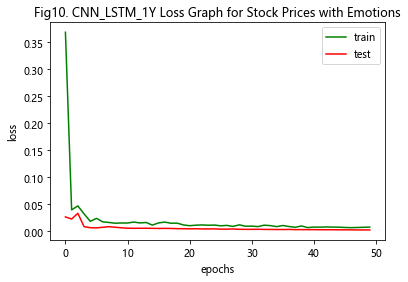

In [50]:
drawLossGraph(history_CL, title='CNN_LSTM_1Y Loss Graph for Stock Prices with Emotions', num='10')

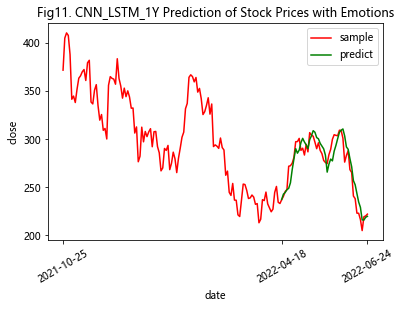

In [51]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_CL = model_CL.predict(X_test_CL)[:,0]

# 反归一化
# 重新读取 TSLA股票价格融合情感.csv
CLwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv')
col_n_CL = CLwithEmotion.shape[1]-2
# 预测结果反归一化
inv_yPredict_CL = inverse_transform_col(scaler_CL, y_predict_CL, col_n_CL)
# 真实结果反归一化
inv_yTest_CL = inverse_transform_col(scaler_CL, y_test_CL, col_n_CL)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_CL = inverse_transform_col(scaler_CL, y_train_CL, col_n_CL)
# 绘图
predictGraph(inv_yTrain_CL, inv_yPredict_CL, inv_yTest_CL, timelabels=CLwithEmotion['Date'].values, title='CNN_LSTM_1Y Prediction of Stock Prices with Emotions', num='11')

In [52]:
# 输出MSE MAE R方评估值
MSE_error_CL = mean_squared_error(y_test_CL, y_predict_CL)
RMSE_CL = math.sqrt(MSE_error_CL)
MAE_CL = mean_absolute_error(y_test_CL, y_predict_CL)
R_square_CL = r2_score(y_test_CL, y_predict_CL)
print('The Mean Squared Error is {}'.format(MSE_error_CL))
print('The Root Mean Squared Error is:')
print(RMSE_CL)
print('The Mean Absolute Error is:',MAE_CL)
print('R Square is {}'.format(R_square_CL))

The Mean Squared Error is 0.0027778864445172995
The Root Mean Squared Error is:
0.052705658562599324
The Mean Absolute Error is: 0.04250401884317398
R Square is 0.8636005709520653


In [53]:
print(model_CL.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 32)             288       
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 32)             8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 161       
_________________________________________________________________
activation (Activation)      (None, 1)                

### 4.2.3 在CNN_LSTM机制中添加Attention机制的预测模型

In [54]:
def CNN_LSTM_AT_Generator(Xtrain, Xtest, ytrain, ytest):
   
   # Build CLA Model
    inputs = Input(shape = (Xtrain.shape[1], Xtrain.shape[2]))   
    x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu', padding="same")(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(64, return_sequences=True,activation='relu')(x)
    previous_out = Dropout(0.2)(x)
    
    
    # ATTENTION PART STARTS HERE
    attention_probs = Dense(64, activation='sigmoid', name='attention_vec')(previous_out)

    attention_mul =Multiply()([previous_out, attention_probs])
    
    attention_mul = Flatten()(attention_mul)

    output = Dense(1, activation='sigmoid')(attention_mul)
    _model = Model(inputs=inputs, outputs=output)
    
    # Compile
    _model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae'])
    # train the model
    es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    _history = _model.fit(Xtrain, ytrain, batch_size=20, epochs=50, validation_data=(Xtest, ytest), callbacks=[es_cb], verbose=2)
    return _history,_model
  
history_CLA, model_CLA = CNN_LSTM_AT_Generator(X_train_CL, X_test_CL, y_train_CL, y_test_CL)

Train on 125 samples, validate on 50 samples
Epoch 1/50
125/125 - 1s - loss: 0.0574 - acc: 0.0080 - mae: 0.2039 - val_loss: 0.0484 - val_acc: 0.0200 - val_mae: 0.1724
Epoch 2/50
125/125 - 0s - loss: 0.0539 - acc: 0.0080 - mae: 0.1977 - val_loss: 0.0482 - val_acc: 0.0200 - val_mae: 0.1757
Epoch 3/50
125/125 - 0s - loss: 0.0496 - acc: 0.0080 - mae: 0.1887 - val_loss: 0.0479 - val_acc: 0.0200 - val_mae: 0.1808
Epoch 4/50
125/125 - 0s - loss: 0.0428 - acc: 0.0080 - mae: 0.1721 - val_loss: 0.0464 - val_acc: 0.0200 - val_mae: 0.1845
Epoch 5/50
125/125 - 0s - loss: 0.0351 - acc: 0.0080 - mae: 0.1564 - val_loss: 0.0319 - val_acc: 0.0200 - val_mae: 0.1408
Epoch 6/50
125/125 - 0s - loss: 0.0247 - acc: 0.0080 - mae: 0.1292 - val_loss: 0.0176 - val_acc: 0.0200 - val_mae: 0.0970
Epoch 7/50
125/125 - 0s - loss: 0.0194 - acc: 0.0080 - mae: 0.1135 - val_loss: 0.0121 - val_acc: 0.0200 - val_mae: 0.0915
Epoch 8/50
125/125 - 0s - loss: 0.0152 - acc: 0.0080 - mae: 0.0946 - val_loss: 0.0100 - val_acc: 0.02

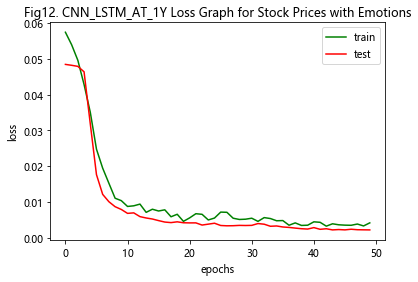

In [55]:
drawLossGraph(history_CLA, title='CNN_LSTM_AT_1Y Loss Graph for Stock Prices with Emotions', num='12')

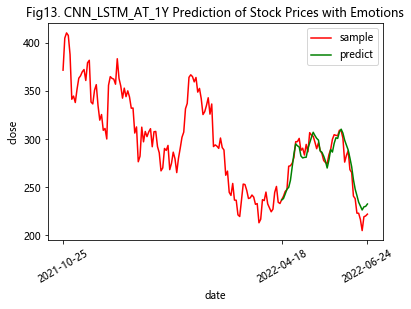

In [56]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_CLA = model_CLA.predict(X_test_CL)[:,0]

# 反归一化
# 重新读取 TSLA股票价格融合情感.csv
CLAwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv')
col_n_CLA = CLAwithEmotion.shape[1]-2
# 预测结果反归一化
inv_yPredict_CLA = inverse_transform_col(scaler_CL, y_predict_CLA, col_n_CLA)
# 真实结果反归一化
inv_yTest_CLA = inverse_transform_col(scaler_CL, y_test_CL, col_n_CLA)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_CLA = inverse_transform_col(scaler_CL, y_train_CL, col_n_CLA)
# 绘图
predictGraph(inv_yTrain_CLA, inv_yPredict_CLA, inv_yTest_CLA, timelabels=CLAwithEmotion['Date'].values, title='CNN_LSTM_AT_1Y Prediction of Stock Prices with Emotions', num='13')

In [57]:
# 输出MSE MAE R方评估值
MSE_error_CLA = mean_squared_error(y_test_CL, y_predict_CLA)
RMSE_CLA = math.sqrt(MSE_error_CLA)
MAE_CLA = mean_absolute_error(y_test_CL, y_predict_CLA)
R_square_CLA = r2_score(y_test_CL, y_predict_CLA)
print('The Mean Squared Error is {}'.format(MSE_error_CLA))
print('The Root Mean Squared Error is:')
print(RMSE_CLA)
print('The Mean Absolute Error is:',MAE_CLA)
print('R Square is {}'.format(R_square_CLA))

The Mean Squared Error is 0.0021427401409643302
The Root Mean Squared Error is:
0.04628974120649553
The Mean Absolute Error is: 0.03588237695395947
R Square is 0.894787444460707


### 4.2.4 建立CNN_BILSTM机制的预测模型

In [58]:
# 读取数据
CBwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv', parse_dates=['Date'], index_col='Date').values
CBwithEmotion

array([[3.16843323e+02, 3.48339996e+02, 3.14733337e+02, ...,
        4.88038517e-02, 7.20361750e-02, 3.41619995e+02],
       [3.41563324e+02, 3.64980011e+02, 3.33813324e+02, ...,
        7.68664389e-02, 8.51711347e-02, 3.39476654e+02],
       [3.46553345e+02, 3.56959991e+02, 3.43593323e+02, ...,
        5.11512681e-02, 8.35095523e-02, 3.45953339e+02],
       ...,
       [2.29500000e+02, 2.29820007e+02, 2.17250000e+02, ...,
        6.25000000e-02, 1.60282258e-01, 2.20190002e+02],
       [2.19800003e+02, 2.22929993e+02, 2.17779999e+02, ...,
        1.42857143e-02, 9.02331002e-02, 2.22039993e+02],
       [2.08279999e+02, 2.15550003e+02, 2.02000000e+02, ...,
        6.95105820e-02, 5.45836710e-02, 2.07279999e+02]])

In [59]:
# 生成归一化容器
# feature_range参数沿用默认(0,1)
scaler_CB = MinMaxScaler(feature_range=(0,1))
# 训练模型
scaler_CB = scaler_CB.fit(CBwithEmotion)
# 归一化
CBwithEmotion = scaler_CB.fit_transform(CBwithEmotion)
# 部分结果展示
CBwithEmotion[:6,:]

array([[0.53504974, 0.66746527, 0.55351887, 1.        , 0.0976077 ,
        0.27013566, 0.6665528 ],
       [0.65651201, 0.75110585, 0.6472013 , 0.99145809, 0.15373288,
        0.31939176, 0.65609646],
       [0.68103059, 0.71079344, 0.69522093, 0.52462323, 0.10230254,
        0.31316082, 0.68769312],
       [0.72795466, 0.7277495 , 0.73355156, 0.30353597, 0.12098622,
        0.28073713, 0.75140664],
       [0.75014738, 0.78506798, 0.76466451, 0.35640165, 0.0975209 ,
        0.26562413, 0.81151011],
       [0.90651203, 0.95291869, 0.89463179, 0.44844756, 0.09171244,
        0.14868238, 0.97389986]])

In [60]:
# 使用series_to_supervised函数构建有监督数据集
CBwithEmotion = series_to_supervised(CBwithEmotion)
CBwithEmotion

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.535050,0.667465,0.553519,1.000000,0.097608,0.270136,0.666553,0.656096
2,0.656512,0.751106,0.647201,0.991458,0.153733,0.319392,0.656096,0.687693
3,0.681031,0.710793,0.695221,0.524623,0.102303,0.313161,0.687693,0.751407
4,0.727955,0.727750,0.733552,0.303536,0.120986,0.280737,0.751407,0.811510
5,0.750147,0.785068,0.764665,0.356402,0.097521,0.265624,0.811510,0.973900
...,...,...,...,...,...,...,...,...
175,0.063876,0.051270,0.063830,0.273399,0.094843,0.355849,0.056152,0.000000
176,0.078911,0.053833,0.010606,0.383393,0.000000,0.625000,0.000000,0.070056
177,0.010269,0.031717,0.036579,0.289135,0.400000,0.000000,0.070056,0.074154
178,0.105886,0.071728,0.074877,0.266095,0.125000,0.601058,0.074154,0.083179


In [61]:
# 必须规定ndarray的dtype为float32（默认float64），否则后续输入模型报错
CBwithEmotion = CBwithEmotion.values.astype(np.float32)

In [62]:
future_days = 0
y = CBwithEmotion[future_days:, 6]
print(y.shape)
X = CBwithEmotion[:len(CBwithEmotion) - future_days, :]
print(X.shape)

(179,)
(179, 8)


In [63]:
#time_steps = 10
time_steps = 5
X_new = np.zeros((X.shape[0] - time_steps + 1, time_steps, X.shape[1]))
y_new = np.zeros((y.shape[0] - time_steps + 1, 1))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :] = X[ix + jx, :]
    y_new[ix] = y[ix + time_steps -1]
print(X_new.shape, y_new.shape)

(175, 5, 8) (175, 1)


In [64]:
split = int(0.7 * CBwithEmotion.shape[0])
X_train_CB = X_new[:split]
X_test_CB = X_new[split:]

y_train_CB = y_new[:split]
y_test_CB = y_new[split:]

print(X_train_CB.shape, y_train_CB.shape)
print(X_test_CB.shape, y_test_CB.shape)
print(X_train_CB.shape[1], X_train_CB.shape[2])

(125, 5, 8) (125, 1)
(50, 5, 8) (50, 1)
5 8


In [65]:
def CNN_BILSTM_Generator(Xtrain, Xtest, ytrain, ytest):
    """
    LSTM模型搭建函数
    :param Xtrain: 训练集属性
    :param Xtest: 测试集属性
    :param ytrain: 训练集标签
    :param ytest: 测试集标签
    :return: history,model（模型编译记录和模型）
    """
   # 搭建模型
    _model = Sequential()
    
    _model.add(Conv1D(32, 3, input_shape=(Xtrain.shape[1], Xtrain.shape[2]), padding="same"))
    _model.add(MaxPooling1D(pool_size=2))
    _model.add(Dropout(0.2))
    _model.add(Bidirectional(LSTM(32, return_sequences=True)))
    _model.add(Dropout(0.2))
    #_model.add(Conv1D(16, 3, padding="same"))
    #_model.add(MaxPooling1D(pool_size=2))
    _model.add(Flatten())
    _model.add(Dense(units=1))
    _model.add(Activation('linear'))
    
    # 模型编译
    _model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae'])
    # 模型训练
    es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    _history = _model.fit(Xtrain, ytrain, batch_size=20, epochs=50, validation_data=(Xtest, ytest), callbacks=[es_cb], verbose=2)
    return _history,_model
  
history_CB, model_CB = CNN_BILSTM_Generator(X_train_CB, X_test_CB, y_train_CB, y_test_CB)

Train on 125 samples, validate on 50 samples
Epoch 1/50
125/125 - 2s - loss: 0.2361 - acc: 0.0000e+00 - mae: 0.4282 - val_loss: 0.0266 - val_acc: 0.0200 - val_mae: 0.1467
Epoch 2/50
125/125 - 0s - loss: 0.0349 - acc: 0.0080 - mae: 0.1435 - val_loss: 0.0131 - val_acc: 0.0200 - val_mae: 0.0973
Epoch 3/50
125/125 - 0s - loss: 0.0386 - acc: 0.0080 - mae: 0.1633 - val_loss: 0.0238 - val_acc: 0.0200 - val_mae: 0.1407
Epoch 4/50
125/125 - 0s - loss: 0.0241 - acc: 0.0080 - mae: 0.1283 - val_loss: 0.0062 - val_acc: 0.0200 - val_mae: 0.0603
Epoch 5/50
125/125 - 0s - loss: 0.0163 - acc: 0.0080 - mae: 0.0993 - val_loss: 0.0047 - val_acc: 0.0200 - val_mae: 0.0541
Epoch 6/50
125/125 - 0s - loss: 0.0160 - acc: 0.0080 - mae: 0.0978 - val_loss: 0.0045 - val_acc: 0.0200 - val_mae: 0.0518
Epoch 7/50
125/125 - 0s - loss: 0.0131 - acc: 0.0080 - mae: 0.0915 - val_loss: 0.0048 - val_acc: 0.0200 - val_mae: 0.0526
Epoch 8/50
125/125 - 0s - loss: 0.0134 - acc: 0.0080 - mae: 0.0933 - val_loss: 0.0051 - val_acc: 

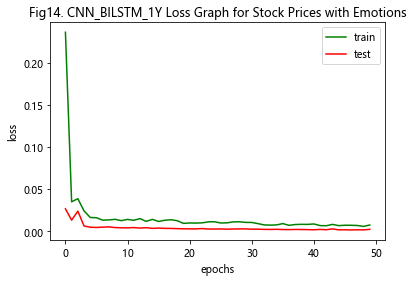

In [66]:
drawLossGraph(history_CB, title='CNN_BILSTM_1Y Loss Graph for Stock Prices with Emotions', num='14')

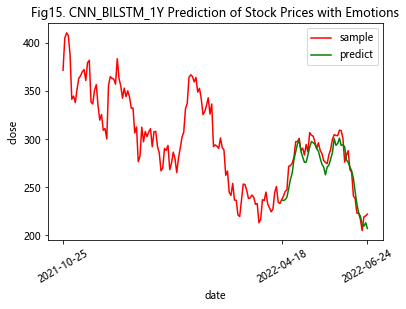

In [67]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_CB = model_CB.predict(X_test_CB)[:,0]

# 反归一化
# 重新读取 TSLA股票价格融合情感.csv
CBwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv')
col_n_CB = CBwithEmotion.shape[1]-2
# 预测结果反归一化
inv_yPredict_CB = inverse_transform_col(scaler_CB, y_predict_CB, col_n_CB)
# 真实结果反归一化
inv_yTest_CB = inverse_transform_col(scaler_CB, y_test_CB, col_n_CB)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_CB = inverse_transform_col(scaler_CB, y_train_CB, col_n_CB)
# 绘图
predictGraph(inv_yTrain_CB, inv_yPredict_CB, inv_yTest_CB, timelabels=CBwithEmotion['Date'].values, title='CNN_BILSTM_1Y Prediction of Stock Prices with Emotions', num='15')

In [68]:
# 输出MSE MAE R方评估值
MSE_error_CB = mean_squared_error(y_test_CB, y_predict_CB)
RMSE_CB = math.sqrt(MSE_error_CB)
MAE_CB = mean_absolute_error(y_test_CB, y_predict_CB)
R_square_CB = r2_score(y_test_CB, y_predict_CB)
print('The Mean Squared Error is {}'.format(MSE_error_CB))
print('The Root Mean Squared Error is:')
print(RMSE_CB)
print('The Mean Absolute Error is:',MAE_CB)
print('R Square is {}'.format(R_square_CB))

The Mean Squared Error is 0.0022280538286311028
The Root Mean Squared Error is:
0.04720226507945464
The Mean Absolute Error is: 0.039792696703225376
R Square is 0.8905983825533389


In [69]:
print(model_CB.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 5, 32)             800       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 32)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 32)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2, 64)             16640     
_________________________________________________________________
dropout_8 (Dropout)          (None, 2, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

### 4.2.5 在CNN_BILSTM机制中添加Attention机制的预测模型

In [70]:
def CNN_BILSTM_AT_Generator(Xtrain, Xtest, ytrain, ytest):
    """
    LSTM模型搭建函数
    :param Xtrain: 训练集属性
    :param Xtest: 测试集属性
    :param ytrain: 训练集标签
    :param ytest: 测试集标签
    :return: history,model（模型编译记录和模型）
    """
   # 搭建模型
    inputs = Input(shape = (Xtrain.shape[1], Xtrain.shape[2]))   
    x = Conv1D(filters = 64, kernel_size = 3, activation = 'relu', padding="same")(inputs)
    #x = MaxPooling1D(pool_size = 2)(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=True,activation='relu'),name='bilstm')(x)
    previous_out = Dropout(0.2)(x)
     
    # ATTENTION PART STARTS HERE
    attention_probs = Dense(128, activation='sigmoid', name='attention_vec')(previous_out)

    attention_mul =Multiply()([previous_out, attention_probs])
    
    attention_mul = Flatten()(attention_mul)

    output = Dense(1, activation='sigmoid')(attention_mul)
    _model = Model(inputs=inputs, outputs=output)
    
    # 模型编译
    _model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae'])
    # 模型训练
    es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    _history = _model.fit(Xtrain, ytrain, batch_size=20, epochs=50, validation_data=(Xtest, ytest), callbacks=[es_cb], verbose=2)
    return _history,_model
  
history_CBA, model_CBA = CNN_BILSTM_AT_Generator(X_train_CB, X_test_CB, y_train_CB, y_test_CB)

Train on 125 samples, validate on 50 samples
Epoch 1/50
125/125 - 1s - loss: 0.0576 - acc: 0.0080 - mae: 0.2049 - val_loss: 0.0495 - val_acc: 0.0200 - val_mae: 0.1761
Epoch 2/50
125/125 - 0s - loss: 0.0518 - acc: 0.0080 - mae: 0.1932 - val_loss: 0.0507 - val_acc: 0.0200 - val_mae: 0.1859
Epoch 3/50
125/125 - 0s - loss: 0.0452 - acc: 0.0080 - mae: 0.1772 - val_loss: 0.0514 - val_acc: 0.0200 - val_mae: 0.1964
Epoch 4/50
125/125 - 0s - loss: 0.0377 - acc: 0.0080 - mae: 0.1603 - val_loss: 0.0366 - val_acc: 0.0200 - val_mae: 0.1555
Epoch 5/50
125/125 - 0s - loss: 0.0273 - acc: 0.0080 - mae: 0.1356 - val_loss: 0.0208 - val_acc: 0.0200 - val_mae: 0.1051
Epoch 6/50
125/125 - 0s - loss: 0.0160 - acc: 0.0080 - mae: 0.1037 - val_loss: 0.0132 - val_acc: 0.0200 - val_mae: 0.0951
Epoch 7/50
125/125 - 0s - loss: 0.0140 - acc: 0.0080 - mae: 0.0936 - val_loss: 0.0134 - val_acc: 0.0200 - val_mae: 0.0955
Epoch 8/50
125/125 - 0s - loss: 0.0161 - acc: 0.0080 - mae: 0.0986 - val_loss: 0.0094 - val_acc: 0.02

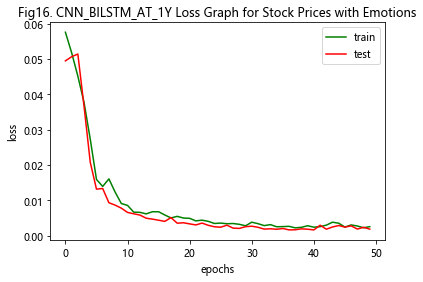

In [71]:
drawLossGraph(history_CBA, title='CNN_BILSTM_AT_1Y Loss Graph for Stock Prices with Emotions', num='16')

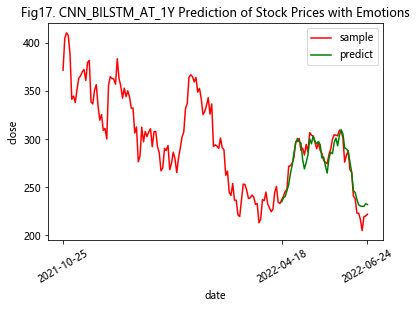

In [72]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_CBA = model_CBA.predict(X_test_CB)[:,0]

# 反归一化
# 重新读取 TSLA股票价格融合情感.csv
CBAwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv')
col_n_CBA = CBAwithEmotion.shape[1]-2
# 预测结果反归一化
inv_yPredict_CBA = inverse_transform_col(scaler_CB, y_predict_CBA, col_n_CBA)
# 真实结果反归一化
inv_yTest_CBA = inverse_transform_col(scaler_CB, y_test_CB, col_n_CBA)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_CBA = inverse_transform_col(scaler_CB, y_train_CB, col_n_CBA)
# 绘图
predictGraph(inv_yTrain_CBA, inv_yPredict_CBA, inv_yTest_CBA, timelabels=CBAwithEmotion['Date'].values, title='CNN_BILSTM_AT_1Y Prediction of Stock Prices with Emotions', num='17')

In [73]:
# 输出MSE MAE R方评估值
MSE_error_CBA = mean_squared_error(y_test_CB, y_predict_CBA)
RMSE_CBA = math.sqrt(MSE_error_CBA)
MAE_CBA = mean_absolute_error(y_test_CB, y_predict_CBA)
R_square_CBA = r2_score(y_test_CB, y_predict_CBA)
print('The Mean Squared Error is {}'.format(MSE_error_CBA))
print('The Root Mean Squared Error is:')
print(RMSE_CBA)
print('The Mean Absolute Error is:',MAE_CBA)
print('R Square is {}'.format(R_square_CBA))

The Mean Squared Error is 0.0018869052668874767
The Root Mean Squared Error is:
0.04343852284421602
The Mean Absolute Error is: 0.034069128707051276
R Square is 0.9073494161077146


In [74]:
print(model_CBA.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5, 8)]       0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 5, 64)        1600        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 5, 64)        0           conv1d_3[0][0]                   
__________________________________________________________________________________________________
bilstm (Bidirectional)          (None, 5, 128)       66048       dropout_9[0][0]                  
____________________________________________________________________________________________

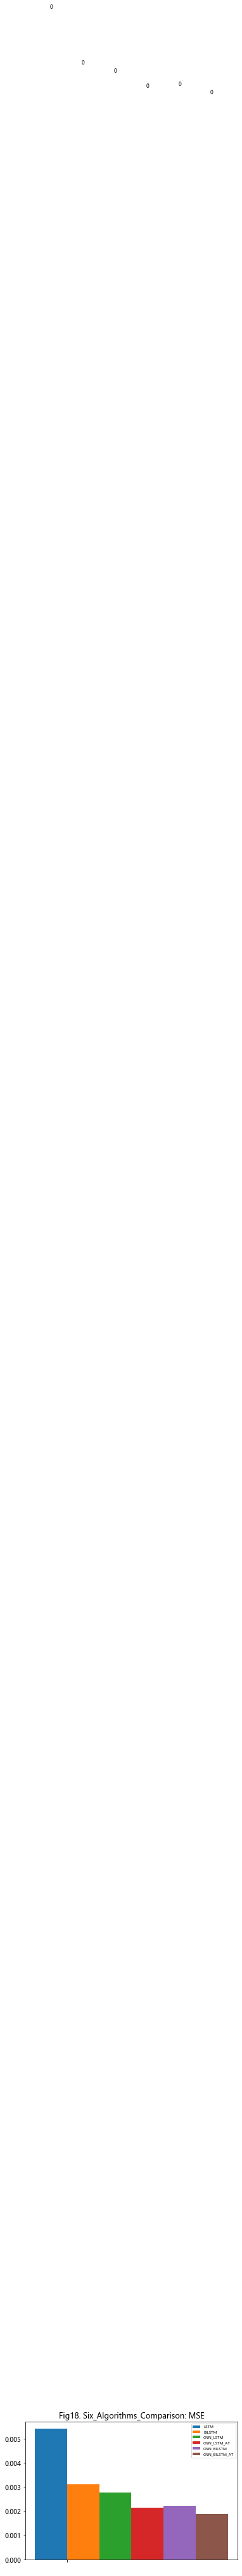

In [75]:
# 绘制6种算法的估值比较图
#import matplotlib
#import matplotlib.pyplot as plt
#import numpy as np

def drawHistogram(title, num):
    matplotlib.rc("font", family='MicroSoft YaHei')
    
    list1 = np.array([MSE_error_LSTM])   # 柱状图第一组数据
    list2 = np.array([MSE_error_BI])   # 柱状图第二组数据
    list3 = np.array([MSE_error_CL])   # 柱状图第三组数据
    list4 = np.array([MSE_error_CLA])   # 柱状图第四组数据
    list5 = np.array([MSE_error_CB])   # 柱状图第五组数据
    list6 = np.array([MSE_error_CBA])   # 柱状图第六组数据
    
    length = len(list1)
    x = np.arange(length)   # 横坐标范围
    x_label = [" "]

    plt.figure()
    total_width, n = 2.4 , 6   # 柱状图总宽度，有几组数据
    width = total_width / n   # 单个柱状图的宽度
    x1 = x - width / 2   # 第一组数据柱状图横坐标起始位置
    x2 = x1 + width   # 第二组数据柱状图横坐标起始位置
    x3 = 2*width + x1
    x4 = 3*width + x1
    x5 = 4*width + x1
    x6 = 5*width + x1
    # 标题
    plt.title('Fig'+num+'. '+title)

    plt.bar(x1, list1, width=width, label="LSTM")
    plt.bar(x2, list2, width=width, label="BILSTM")
    plt.bar(x3, list3, width=width, label="CNN_LSTM")
    plt.bar(x4, list4, width=width, label="CNN_LSTM_AT")
    plt.bar(x5, list5, width=width, label="CNN_BILSTM")
    plt.bar(x6, list6, width=width, label="CNN_BILSTM_AT")
    
    for a, b in zip(x1, list1):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)

    for a, b in zip(x2, list2):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)
    
    for a, b in zip(x3, list3):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)

    for a, b in zip(x4, list4):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)
    
    for a, b in zip(x5, list5):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)

    for a, b in zip(x6, list6):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)

    plt.xticks(x, x_label)   
    # 给出图例
    plt.legend(loc=1, prop={'size': 6})
    
    
    # 保存于 file/
    #savingPath = 'file/Fig'+num+'_'+title.replace(' ', '_')+'.png'
    #plt.savefig(savingPath, dpi=400, bbox_inches='tight')
    plt.show()

if __name__ == '__main__':
    drawHistogram(title = 'Six_Algorithms_Comparison: MSE', num = '18')

### 从Fig18来看，CNN_BILSTM_AT 在一年的预测中表现最佳